<a href="https://colab.research.google.com/github/fcastellanosp/MINE-4210_202420_ADL/blob/main/Talleres/Taller%202/MINE4210_ADL2024_Taller2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/fcastellanosp/MINE-4210_202420_ADL/blob/main/Laboratorios/logo_adl.png?raw=true)

# **Taller 2**

- **Integrante 1:**
- **Integrante 2:**

Bangladesh es una de los países con más tráfico en el mundo. Allí se encuentran algunas particularidades como los *rickshaw*, que son vehículos de 2 ruedas impulsados por una persona.

Los estudios indican que alrededos de 3.000 personas fallecen al año a causa de accidentes de tránsito.

Como consultor del sector de transporte, la organización ha procesado alrededor de 20.000 imágenes etiquetadas con información de objetos que pertenecen a las siguientes 13 clases:

* person
* rickshaw
* rickshaw van
* auto rickshaw
* truck
* pickup truck
* private car
* motorcycle
* bicycle
* bus
* micro bus
* covered van
* human hauler

Han sido contratados para buscar un proceso que permita acelerar el entendimiento de esta problemática, para el cuál le solicitan construir un modelo de detección de objetos que permita identificar los diferentes actores viales.

La información etiquetada se encuentra en  "[Bangladesh traffic](https://www.kaggle.com/datasets/hasibzunair/rsud20k-bangladesh-road-scene-understanding)".

# **Preguntas:**

1.   Construir una red neuronal de detección de objetos usando un modelo pre-entrenado. Recuerden ser descriptivos en el Preprocesamiento de Datos, Utilización de Modelos Pre-entrenados, Evaluación de Rendimiento y búsqueda de hiperparámetros.

2.  Proporcionar algunos ejemplos de detección de objetos con la red entrenada y lo comparen con la imagen con los datos anotados. Traten de usar imágenes con 1 objeto asi como imágenes con varios objetos.

3.  Investigar la métrica mAP y cómo la interpreta para la red entrenada.

4. Calcular el número de escenarios (imágenes) que involucran personas en el conjunto de prueba.

# **Notas Importantes:**
- Pueden usar la versión de Yolo del laboratorio u otra distinta.
- El archivo a presentar debe ser en formato .ipynb o HTML ya ejecutado. Celda que no esté ejecutada no se podrá evaluar.
- El nombre del archivo debe ser `Taller_2_{Apellido_Nombre}_{Apellido_Nombre}` de cada integrante respectivamente.

# 0.Librerias

In [ ]:
!pip install pandas
!pip install numpy
!pip install keras-tuner -q
!pip install kaggle -q
!pip install scikeras -q
!pip install ultralytics==8.2.98

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()


Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 46.8/107.7 GB disk)


In [ ]:
# Importar bibliotecas esenciales
import time
import numpy as np
import pandas as pd
import os
import os.path as osp
import random
import re
import shutil
import tensorflow as tf
import torch

#Visualización de datos
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


from IPython.display import display, Image

from numpy import asarray

from PIL import Image

from ultralytics import YOLO

# Profiling de datos
from tensorflow.keras import layers, models

# Cargar archivos en Colab
from google.colab import drive


In [ ]:
!nvidia-smi

Wed Oct  2 03:48:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Definir variables de configuración global
my_seed = 19  # Semilla para reproducibilidad
image_ext = ['.jpg', '.jpeg', '.png', '.bmp']  # Extensiones válidas de imagen
label_ext = '.txt'  # Extensión válida de las etiquetas de texto
YOLO_VERSION = 'yolov8m.pt'  # Versión del modelo YOLO

# Configurar semilla para asegurar reproducibilidad
random.seed(my_seed)
np.random.seed(my_seed)
torch.manual_seed(my_seed)

# Configura la semilla para la GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(my_seed)

In [ ]:
random.seed(my_seed)

#1. Datos

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -lha /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2/
!mkdir -p /root/.kaggle
!cp /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

total 11G
-rw------- 1 root root 1.5K Oct  2 12:51 data.yaml
-rw------- 1 root root   63 Sep 26 03:56 kaggle.json
drwx------ 3 root root 4.0K Sep 28 16:59 rsud20k-bangladesh-road-scene-understanding
-rw------- 1 root root  11G Feb  2  2024 rsud20k-bangladesh-road-scene-understanding.zip
drwx------ 3 root root 4.0K Oct  1 13:46 runs
-rw------- 1 root root 851K Oct  2 12:56 Taller2.ipynb
-rw------- 1 root root  50M Oct  1 14:00 yolov8m.pt
-rw------- 1 root root 6.3M Oct  1 13:46 yolov8n.pt


In [ ]:
!kaggle datasets download hasibzunair/rsud20k-bangladesh-road-scene-understanding -p /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2/

Dataset URL: https://www.kaggle.com/datasets/hasibzunair/rsud20k-bangladesh-road-scene-understanding
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 10.2G/10.2G [11:20<00:00, 18.3MB/s]
100% 10.2G/10.2G [11:20<00:00, 16.1MB/s]


In [ ]:
# Definir las variables
ROOT_DIR = '/content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2/'
DATASET_NAME = 'rsud20k-bangladesh-road-scene-understanding'
SUB_DATASET_NAME = 'rsud20k'

# Cambiar directorio al lugar donde se descargó el archivo
%cd {ROOT_DIR}


/content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2


In [ ]:
# Descomprimir el dataset
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6370.txt  
  inflating: /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6371.txt  
  inflating: /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6372.txt  
  inflating: /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6373.txt  
  inflating: /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train/train6374.txt  
  inflating: /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/labels

In [ ]:
DATA_DIR = f"{ROOT_DIR}/{DATASET_NAME}/{SUB_DATASET_NAME}"
print(DATA_DIR)

/content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k


In [ ]:
subdirs = ['images', 'labels']

In [ ]:
images_folder = osp.join(DATA_DIR, subdirs[0])
test_ima_fol = osp.join(images_folder, "test")
train_ima_fol = osp.join(images_folder, "train")
val_ima_fol = osp.join(images_folder, "val")
labels_folder = osp.join(DATA_DIR, subdirs[1])
test_lab_fol = osp.join(labels_folder, "test")
train_lab_fol = osp.join(labels_folder, "train")
val_lab_fol = osp.join(labels_folder, "val")

In [ ]:
folder_list = [test_ima_fol, train_ima_fol,
                val_ima_fol, test_lab_fol,
                train_lab_fol, val_lab_fol
]

print("Imprimimos las rutas de las carpetas:")
for fa in folder_list:
  print(fa)
  print(f"¿La ruta es válida?: {osp.exists(fa)}")

Imprimimos las rutas de las carpetas:
/content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/images/test
¿La ruta es válida?: True
/content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/images/train
¿La ruta es válida?: True
/content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/images/val
¿La ruta es válida?: True
/content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/test
¿La ruta es válida?: True
/content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train
¿La ruta es válida?: True
/content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/val
¿La ruta es válida?: True


#2. Preprocesamiento de datos

In [ ]:
# Listas para almacenar los datos de las imágenes
img_name_list = []
img_width_list = []
img_height_list = []
img_folder_list = []
img_format_list = []

# Extensiones permitidas para imágenes
IMG_EXT = ['.jpg', '.jpeg', '.png', '.tif', '.bmp']

# Lista de carpetas a procesar
folder_list = [train_ima_fol, test_ima_fol, val_ima_fol]

for fa in folder_list:
    parent_name = os.path.basename(fa)  # Cambiar para obtener la subcarpeta (train, test, val)
    for fname in os.listdir(fa):
        img_folder_list.append(parent_name)  # Aquí se agrega la subcarpeta, no la carpeta principal
        img_name_list.append(fname)
        img_path = osp.join(fa, fname)

        # Validación de formato de imagen
        img_format_list.append("ok" if osp.splitext(fname)[-1].lower() in IMG_EXT else "not ok")

        # Obtener dimensiones de la imagen
        with Image.open(img_path) as img:
            width, height = img.size
            img_width_list.append(width)
            img_height_list.append(height)

# Crear un DataFrame con la información recopilada
data_model = {
    "folder": img_folder_list,
    "image_name": img_name_list,
    "width": img_width_list,
    "height": img_height_list,
    "format": img_format_list
}

report_df = pd.DataFrame(data=data_model)

# Mostrar el DataFrame resultante
print(report_df)


      folder     image_name  width  height format
0      train  train9073.jpg   1920    1080     ok
1      train  train9055.jpg   1920    1080     ok
2      train  train9052.jpg   1920    1080     ok
3      train  train9070.jpg   1920    1080     ok
4      train  train9081.jpg   1920    1080     ok
...      ...            ...    ...     ...    ...
20329    val     val994.jpg   1920    1080     ok
20330    val     val115.jpg   1920    1080     ok
20331    val      val14.jpg   1920    1080     ok
20332    val     val105.jpg   1920    1080     ok
20333    val     val138.jpg   1920    1080     ok

[20334 rows x 5 columns]


In [ ]:
report_df.groupby(['folder', 'format', 'width', 'height']).size()

,,,,0
folder,format,width,height,
test,ok,1920,1080,649
train,ok,1920,1080,18681
val,ok,1920,1080,1004


Impacto en el Rendimiento del Modelo
Positivo: Reducción en el tiempo de entrenamiento e inferencia. Al reducir el tamaño de las imágenes, el modelo necesitará procesar menos píxeles, lo que reduce el tiempo de cálculo y el uso de memoria. Esto es especialmente importante si estás usando un modelo en tiempo real o si tienes limitaciones de hardware (como GPU con poca memoria).
Menos información que procesar por la red, lo que significa menos carga computacional y, por tanto, tiempos de entrenamiento más rápidos.
Esto también puede acelerar el proceso de inferencia (predicción), lo que es crucial para aplicaciones en tiempo real (como cámaras de seguridad o drones).
Negativo: Posible pérdida de precisión. Al reducir el tamaño de las imágenes, pierdes detalles finos que podrían ser importantes para detectar objetos pequeños. Si los objetos en tus imágenes son pequeños o complejos, el modelo podría tener dificultades para detectarlos con precisión después de reducir el tamaño de la imagen.
La red neuronal recibe menos información visual por cada imagen, lo que puede afectar su capacidad para reconocer objetos pequeños o difíciles de ver.
2. Impacto en la Calidad de Detección
Negativo: Si los objetos en tus imágenes originales de 1920x1080 son pequeños en comparación con el tamaño de la imagen, cambiar a 640x640 puede dificultar que el modelo los detecte, ya que la resolución es más baja y se pierde precisión en los cuadros delimitadores (bounding boxes).

Las coordenadas de los cuadros delimitadores (bounding boxes) pueden volverse menos precisas, lo que afecta la detección.
Los detalles pequeños de los objetos se vuelven más borrosos, lo que dificulta que el modelo los aprenda correctamente.
Positivo: Si los objetos son grandes en tus imágenes, reducir el tamaño a 640x640 no tendrá un impacto significativo en la precisión. De hecho, en algunos casos puede ayudar a mejorar la generalización del modelo al eliminar ruido o detalles irrelevantes.

3. Reescalado de las Imágenes (Aspect Ratio)
Tus imágenes originales tienen una relación de aspecto de 1920:1080, es decir, 16:9. Cambiar el tamaño a 640x640 implica cambiar a una relación de aspecto de 1:1 (cuadrada). Esto distorsionará las imágenes a menos que uses un enfoque de redimensionado adecuado.

Soluciones:

Padding (relleno): Agregar bordes a la imagen para mantener la proporción original. Esto evita la distorsión de los objetos, pero agrega píxeles adicionales alrededor de la imagen que no contienen información útil.
Stretching (estiramiento): Ajustar la imagen para que se ajuste exactamente a 640x640. Esto puede distorsionar los objetos si la relación de aspecto cambia.
Center crop (recorte centrado): Cortar los bordes de la imagen para ajustarla a 640x640 sin distorsionar los objetos. Esto podría eliminar parte de la imagen original, pero es útil si los objetos importantes están en el centro.
4. Impacto en la Memoria GPU
Positivo: Al reducir el tamaño de las imágenes, también se reduce la cantidad de memoria que necesita tu GPU para procesar el lote de datos. Esto permite aumentar el tamaño del lote (batch size) durante el entrenamiento, lo que a su vez puede mejorar la estabilidad y la velocidad de convergencia del modelo.
Negativo: Si tu GPU tiene suficiente memoria para procesar imágenes más grandes, podrías estar desperdiciando capacidad de procesamiento al reducir el tamaño de las imágenes.
5. Impacto en la Generalización
Positivo: A menudo, reducir el tamaño de las imágenes puede ayudar a que el modelo generalice mejor, especialmente si las imágenes contienen mucho ruido o detalles irrelevantes. Esto es especialmente cierto cuando los objetos son grandes y se detectan fácilmente, incluso a resoluciones más bajas.
Negativo: Como ya se mencionó, si tus imágenes contienen muchos detalles o si los objetos que deseas detectar son pequeños, el cambio a 640x640 puede hacer que el modelo pierda información importante y no generalice bien a nuevas imágenes.
6. ¿Cuándo es Adecuado Cambiar a 640x640?
Sí: Si los objetos en tus imágenes son lo suficientemente grandes y detectables incluso en una resolución más baja, cambiar el tamaño a 640x640 puede mejorar la eficiencia sin perder precisión.
No: Si tienes objetos pequeños, complejos o si los detalles finos son críticos para el éxito de la detección, debes considerar usar imágenes de mayor resolución o emplear técnicas de reescalado que mantengan la proporción original de los objetos.

In [ ]:
def show_ima_matrix(image_list, show_axis=False):
    MAX_SIZE = 9  # Número máximo de imágenes a mostrar en la matriz

    if len(image_list) != MAX_SIZE:
        print(f"Se requieren exactamente {MAX_SIZE} imágenes para crear la matriz.")
        return

    plt.figure(figsize=(15, 15))  # Definir el tamaño de la figura

    for i in range(MAX_SIZE):
        ima_file = image_list[i]
        ima_name = os.path.basename(ima_file)
        ax = plt.subplot(3, 3, i + 1)

        if os.path.exists(ima_file):  # Verificar si el archivo existe
            plt.imshow(np.array(Image.open(ima_file)))  # Abrir y mostrar la imagen

        plt.title(ima_name[:20])  # Truncar el nombre de la imagen si es muy largo
        plt.axis("on" if show_axis else "off")  # Controlar la visibilidad de los ejes

    plt.tight_layout()  # Ajustar los subplots para que no se solapen
    plt.show()

In [ ]:
ima_list = [filename for filename in os.listdir(train_ima_fol)]
ima_count = len(ima_list)
print(f"El número total de imágenes es: {ima_count}")

El número total de imágenes es: 18681


In [ ]:
#Barajar la lista de imágenes
random.shuffle(ima_list)

In [ ]:
#Crear una lista de rutas completas para las imágenes
ima_fc_list = [osp.join(train_ima_fol, filename) for filename in ima_list]

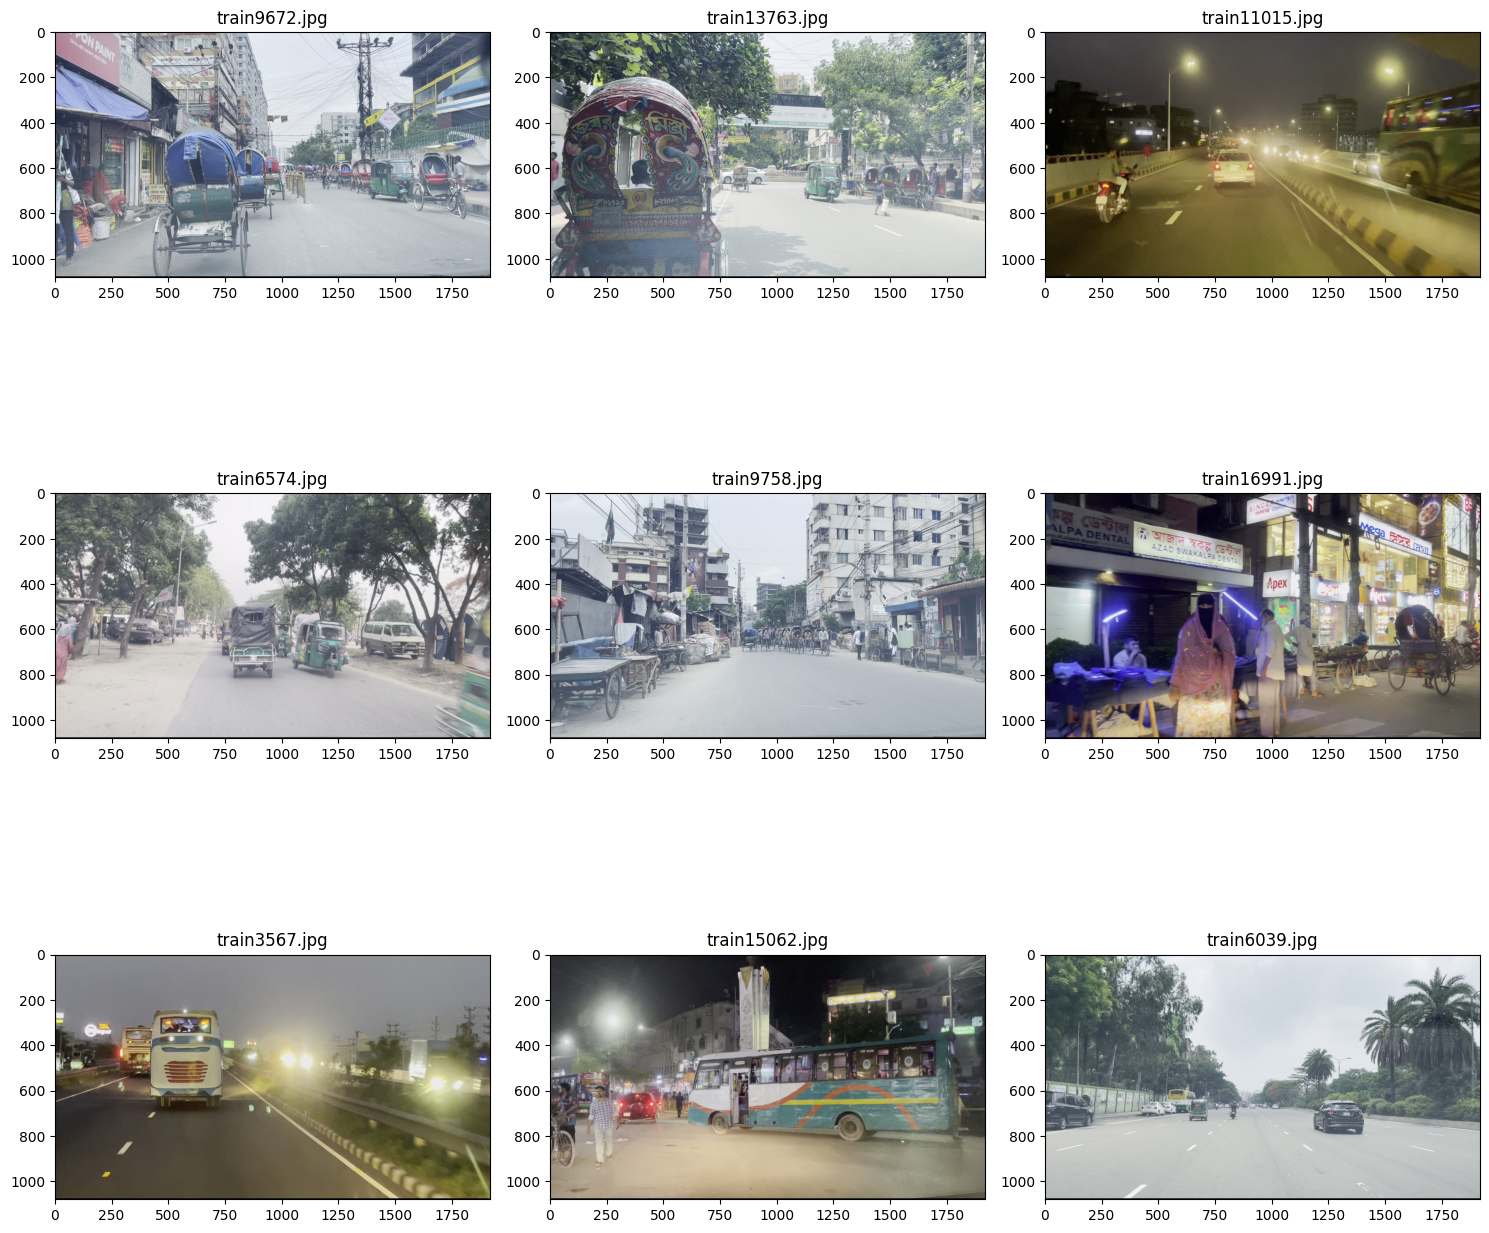

In [ ]:
#Seleccionar una muestra
show_ima_matrix(ima_fc_list[0:9], show_axis=True)

##2.1 Preprocesamiento

In [ ]:
# Definir listas de carpetas de imágenes y etiquetas
image_folders = [train_ima_fol, test_ima_fol, val_ima_fol]
label_folders = [train_lab_fol, test_lab_fol, val_lab_fol]

# Extensiones válidas para imágenes y etiquetas
image_ext = ['.jpg', '.jpeg', '.png']
label_ext = ['.txt']  # Para YOLO generalmente las etiquetas están en .txt

# Función para verificar correspondencia entre imágenes y etiquetas
def verify_alignment(image_folders, label_folders):
    for img_folder, lbl_folder in zip(image_folders, label_folders):
        img_files = [f for f in os.listdir(img_folder) if os.path.splitext(f)[-1].lower() in image_ext]
        lbl_files = [f for f in os.listdir(lbl_folder) if os.path.splitext(f)[-1].lower() in label_ext]

        # Obtener solo el nombre base (sin extensión)
        img_basenames = [os.path.splitext(f)[0] for f in img_files]
        lbl_basenames = [os.path.splitext(f)[0] for f in lbl_files]

        # Verificar imágenes sin etiquetas
        imgs_without_labels = set(img_basenames) - set(lbl_basenames)
        if imgs_without_labels:
            print(f"Imágenes sin etiquetas en la carpeta {img_folder}:")
            for img in imgs_without_labels:
                print(f"{img}")

        # Verificar etiquetas sin imágenes
        labels_without_imgs = set(lbl_basenames) - set(img_basenames)
        if labels_without_imgs:
            print(f"Etiquetas sin imágenes en la carpeta {lbl_folder}:")
            for lbl in labels_without_imgs:
                print(f"{lbl}")

# Ejecutar la verificación
verify_alignment(image_folders, label_folders)

In [ ]:
# Función para cargar una imagen y su etiqueta correspondiente
def load_image_and_label(image_path, label_path):
    # Cargar la imagen
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [150, 150])  # Redimensionar la imagen
    image = image / 255.0  # Normalizar entre 0 y 1

    # Cargar la etiqueta
    label = tf.io.read_file(label_path)
    label = tf.strings.to_number(label, tf.int32)  # Convertir la clase a entero

    return image, label

# Crear listas de rutas de imágenes y etiquetas
train_image_paths = [os.path.join(train_ima_fol, fname) for fname in os.listdir(train_ima_fol)]
train_label_paths = [os.path.join(train_lab_fol, fname.replace('.jpg', '.txt')) for fname in os.listdir(train_ima_fol)]

val_image_paths = [os.path.join(val_ima_fol, fname) for fname in os.listdir(val_ima_fol)]
val_label_paths = [os.path.join(val_ima_fol, fname.replace('.jpg', '.txt')) for fname in os.listdir(val_ima_fol)]

# Crear un dataset de TensorFlow a partir de las rutas de imágenes y etiquetas para el conjunto de entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_label_paths))
train_dataset = train_dataset.map(load_image_and_label)

# Crear un dataset para el conjunto de validación
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_label_paths))
val_dataset = val_dataset.map(load_image_and_label)


##2.2 DAta augmentation y redimensionamiento

Padding se utiliza cuando quieres ajustar el tamaño de tus imágenes a un tamaño fijo (como 640x640) sin distorsionar su relación de aspecto.

In [ ]:
# Función de aumentación con padding y redimensionamiento
def augment(image, label, img_size=640):
    # Flip horizontal
    image = tf.image.random_flip_left_right(image)

    # Rotación limitada
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Rotación de 0 a 270 grados

    # Zoom aleatorio
    scales = tf.constant([0.8, 0.9, 1.0], dtype=tf.float32)  # Zoom entre 80% y 100%
    chosen_scale = tf.random.shuffle(scales)[0]  # Elegir un zoom aleatorio
    boxes = tf.stack([0.5 - 0.5 * chosen_scale, 0.5 - 0.5 * chosen_scale, 0.5 + 0.5 * chosen_scale, 0.5 + 0.5 * chosen_scale])
    boxes = tf.expand_dims(boxes, 0)
    image = tf.image.crop_and_resize([image], boxes=boxes, box_indices=[0], crop_size=[img_size, img_size])
    image = tf.squeeze(image)  # Eliminar la dimensión extra para volver a [height, width, channels]

    # Traslación
    translations = tf.random.uniform([2], minval=-10, maxval=10, dtype=tf.int32)
    image = tf.image.pad_to_bounding_box(image, 10, 10, img_size + 20, img_size + 20)  # Aumentar el tamaño para traslación
    image = tf.image.crop_to_bounding_box(image, translations[0], translations[1], img_size, img_size)  # Recortar de vuelta al tamaño original

    # Ajustar el brillo
    image = tf.image.random_brightness(image, 0.2)

    # Padding: Asegurarse de que la imagen tenga tamaño fijo sin distorsión
    original_height, original_width, _ = tf.shape(image)[0], tf.shape(image)[1], tf.shape(image)[2]
    target_height, target_width = img_size, img_size
    padding_height = (target_height - original_height) // 2
    padding_width = (target_width - original_width) // 2
    image = tf.image.resize_with_pad(image, img_size, img_size)  # Padding para mantener la relación de aspecto

    return image, label

Entrenar modelo

In [ ]:
# Definir el contenido del archivo data.yaml usando las rutas que ya tienes definidas
yaml_content = f"""
# Ruta raíz de las imágenes y etiquetas
train: {train_ima_fol}   # Ruta a las imágenes de entrenamiento
val: {val_ima_fol}       # Ruta a las imágenes de validación
test: {test_ima_fol}     # Ruta a las imágenes de prueba (opcional)

# Rutas a las etiquetas (opcional si se necesita)
train_labels: {train_lab_fol}   # Ruta a las etiquetas de entrenamiento
val_labels: {val_lab_fol}       # Ruta a las etiquetas de validación
test_labels: {test_lab_fol}     # Ruta a las etiquetas de prueba (opcional)

# Clases que el modelo debe detectar
names:
  0: person
  1: rickshaw
  2: rickshaw van
  3: auto rickshaw
  4: truck
  5: pickup truck
  6: private car
  7: motorcycle
  8: bicycle
  9: bus
  10: micro bus
  11: covered van
  12: human hauler
"""

# Crear el archivo data.yaml
with open('data.yaml', 'w') as file:
    file.write(yaml_content)

# Verificar que el archivo se haya creado correctamente
!cat data.yaml



# Ruta raíz de las imágenes y etiquetas
train: /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/images/train   # Ruta a las imágenes de entrenamiento
val: /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/images/val       # Ruta a las imágenes de validación
test: /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/images/test     # Ruta a las imágenes de prueba (opcional)

# Rutas a las etiquetas (opcional si se necesita)
train_labels: /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train   # Ruta a las etiquetas de entrenamiento
val_labels: /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2//rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/val       # Ruta a las etiquetas de 

In [ ]:
model = YOLO(f'{YOLO_VERSION}')  # Puedes cambiar a 'yolov8s.pt' si deseas un modelo más grande

# 4. Entrenar el modelo con los datos organizados en el archivo data.yaml

model.train(
    data='data.yaml',   # Archivo YAML con la configuración del dataset
    epochs=50,          # Número de épocas
    imgsz=640,          # Tamaño de las imágenes
    batch=16,           # Tamaño del lote (ajustado a la memoria de la GPU)
    lr0=0.01,           # Tasa de aprendizaje inicial
    #device=0            # Utilizar GPU (si está disponible)
)

New https://pypi.org/project/ultralytics/8.3.3 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt

train: Scanning /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/train.cache... 18681 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18681/18681 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/Colab_Notebooks/ADL_20242/Talleres/Taller_2/rsud20k-bangladesh-road-scene-understanding/rsud20k/labels/val.cache... 1004 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1004/1004 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/1168 [00:00<?, ?it/s]

La métrica mAP (mean Average Precision) es una de las métricas más importantes en la detección de objetos, ya que mide la precisión media a diferentes umbrales de IoU (Intersection over Union).

mAP @ 0.5: Es la media de precisión calculada cuando IoU es 0.5 (50%). Es decir, cuando el área de intersección entre el cuadro de predicción y el cuadro real es al menos el 50% del área total de los cuadros.
mAP @ 0.5:0.95: Calcula la media de precisión en diferentes umbrales de IoU (desde 0.5 hasta 0.95 con un incremento de 0.05). Esta es una métrica más estricta, ya que requiere un mayor nivel de precisión.

In [ ]:
# Función de aumentación de datos ajustada con redimensionamiento
def augment(image, label, img_size=640):
    # Flip horizontal
    image = tf.image.random_flip_left_right(image)

    # Rotación limitada
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32))  # Rotación de 0 o 90 grados

    # Zoom aleatorio
    scales = tf.constant([0.8, 0.9, 1.0], dtype=tf.float32)  # Zoom entre 80% y 100%
    chosen_scale = tf.random.shuffle(scales)[0]  # Elegir un zoom aleatorio
    boxes = tf.stack([0.5 - 0.5 * chosen_scale, 0.5 - 0.5 * chosen_scale, 0.5 + 0.5 * chosen_scale, 0.5 + 0.5 * chosen_scale])
    boxes = tf.reshape(boxes, [1, 4])  # Asegurarse de que el tensor tenga el formato correcto

    # **Asegurarse de que la imagen tiene la forma correcta [batch, height, width, channels]**
    image = tf.expand_dims(image, axis=0)  # Expande la imagen a 4D [1, height, width, channels]

    # Aplicar el zoom con crop_and_resize
    image = tf.image.crop_and_resize(image, boxes=boxes, box_indices=[0], crop_size=[img_size, img_size])
    image = tf.squeeze(image, axis=0)  # Eliminar la dimensión extra para volver a [height, width, channels]

    # Traslación aleatoria
    translations = tf.random.uniform([2], minval=-10, maxval=10, dtype=tf.int32)
    image = tf.image.pad_to_bounding_box(image, 10, 10, img_size + 20, img_size + 20)  # Aumentar el tamaño para traslación
    image = tf.image.crop_to_bounding_box(image, translations[0], translations[1], img_size, img_size)  # Recortar de vuelta al tamaño original

    # Ajustar el brillo
    image = tf.image.random_brightness(image, 0.2)

    return image, label

# Aplicar la aumentación con redimensionamiento
train_dataset = train_dataset.map(lambda x, y: augment(x, y, img_size=640))

In [ ]:
# Barajar y agrupar en lotes
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_image_paths))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#Modelo

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(640, 640, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(13, activation='softmax')  # Si tienes 13 clases
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Ajusta según tu tarea (detección de objetos)
              metrics=['accuracy'])

# Entrenar el modelo usando los datasets preprocesados
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=20)  # Define el número de épocas que desees